In [77]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
import numbers

# Read data

In [108]:
DATA_FOLDER = "../data/interim/"

df_ratings = pd.read_csv(
    os.path.join(DATA_FOLDER, 'ratings.csv'))
    
df_books = pd.read_csv(
    os.path.join(DATA_FOLDER, 'books.csv'))
    
df_users = pd.read_csv(
    os.path.join(DATA_FOLDER, 'users.csv'))
   

In [109]:
display(df_ratings.head(3))
print(df_ratings.shape)

,user_id,isbn,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


(1149780, 3)


In [110]:
display(df_books.head(3))
print(df_books.shape)

,isbn,title,author,year,publisher,img_url
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...


(266663, 6)


In [111]:
display(df_users.head(3))
print(df_users.shape)

,user_id,location,age,city,country
0,1,"nyc, new york, usa",NaN,nyc,usa
1,2,"stockton, california, usa",18.0,stockton,usa
2,3,"moscow, yukon territory, russia",NaN,moscow,russia


(278858, 5)


# EDA

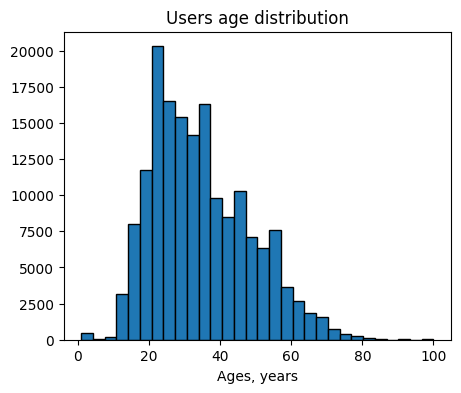

In [112]:
plt.figure(figsize=(5, 4))
plt.hist(df_users['age'], bins=30, edgecolor='black')
plt.title('Users age distribution')
plt.xlabel('Ages, years')
plt.show()

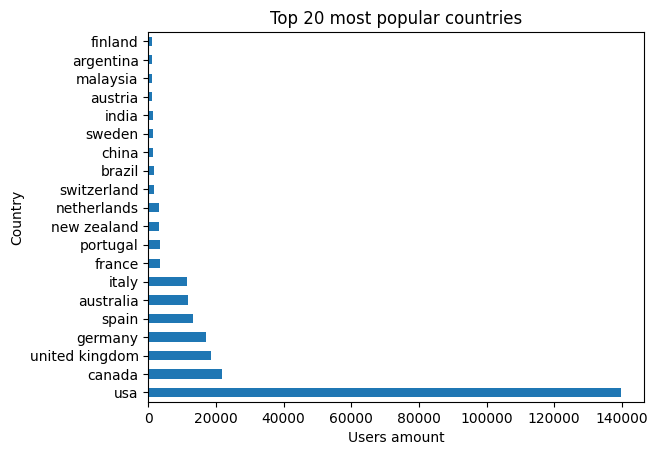

In [113]:
plt.title("Top 20 most popular countries")
df_users['country'].value_counts().head(20).plot.barh()
plt.ylabel('Country')
plt.xlabel('Users amount')
plt.show()

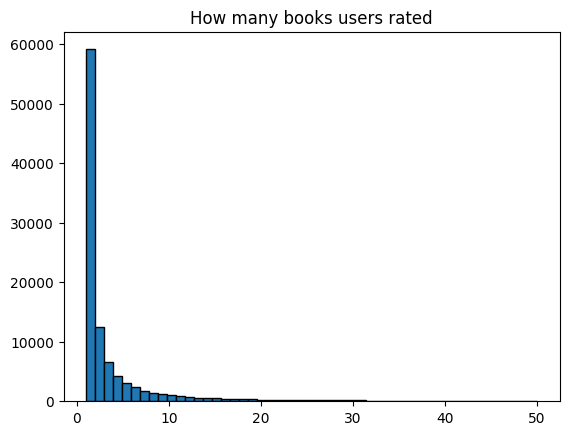

In [114]:
user_intercation_count = df_ratings['user_id'].value_counts()
plt.title('How many books users rated')
plt.hist(
    user_intercation_count[user_intercation_count <= 50], 
    bins=50, 
    edgecolor='black'
)
plt.show()

In [115]:
# Top 30 the most popular books
df_books.loc[df_books['isbn'].isin(df_ratings['isbn'].value_counts().head(30).index), ['isbn', 'title', 'author', 'year']]

,isbn,title,author,year
26,0971880107,Wild Animus,Rich Shapero,2004.0
67,0804106304,The Joy Luck Club,Amy Tan,1994.0
118,0671027360,Angels &amp; Demons,Dan Brown,2001.0
229,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001.0
302,044023722X,A Painted House,John Grisham,2001.0
352,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0
404,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0
452,044021145X,The Firm,John Grisham,1992.0
481,0671021001,She's Come Undone (Oprah's Book Club),Wally Lamb,1998.0
518,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0
